Each software projects incorporates a specific technology stack. We aim to identify the **most common technology combinations** across open-source software projects.

Number of projects: 88
Processing ../data/microservice_projects/Spring-Cloud-Platform.json
Files in the project: ['ace-infrastructure/ace-nacos/nacos/conf/application.properties', 'ace-infrastructure/ace-nacos/nacos/data/derby-data/service.properties', 'ace-infrastructure/ace-nacos/nacos/data/naming/meta.properties', 'ace-modules/ace-generator/src/main/resources/generator.properties']
['maven', 'spring', 'configparser', 'docker', 'docker-compose', 'yaml']
Processing ../data/microservice_projects/spring-boot-microservices.json
Files in the project: ['api-gateway/src/main/resources/application-docker.properties', 'api-gateway/src/main/resources/application.properties', 'discovery-server/src/main/resources/application-docker.properties', 'discovery-server/src/main/resources/application.properties', 'inventory-service/src/main/resources/application-docker.properties', 'inventory-service/src/main/resources/application.properties', 'notification-service/src/main/resources/application-docker.

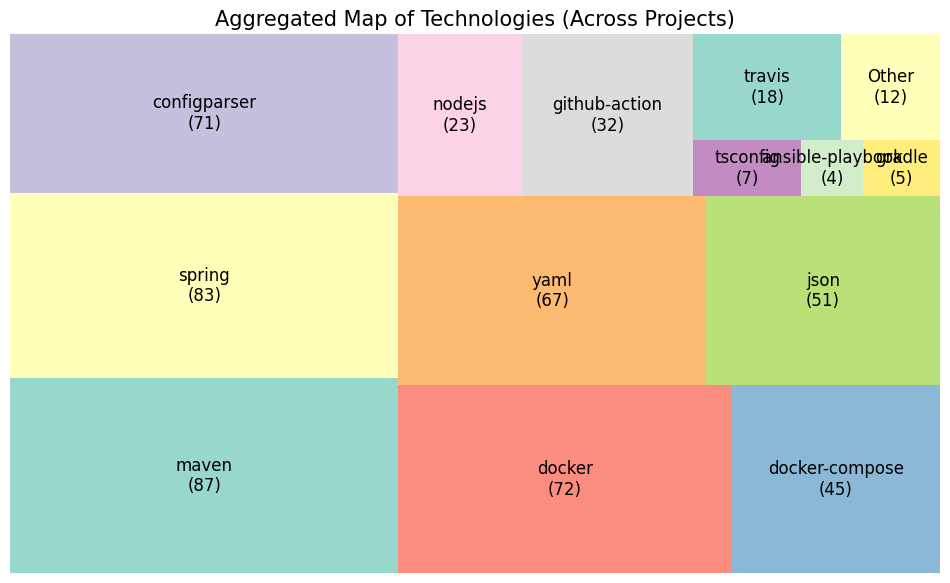

In [24]:
from typing import List, Dict
import matplotlib.pyplot as plt
import squarify
import json
import glob

def plot_used_technologies(project_files: List):

    aggregated_concepts: Dict[str, int] = {}

    for project_file in project_files:
        print(f"Processing {project_file}")
        try:
            with open(project_file, "r", encoding="utf-8") as f:
                data = json.load(f)

                commit_data = data["commit_data"]

                latest_commit = next(filter(lambda commit: commit["is_latest_commit"] == True, commit_data), None)
                concepts = latest_commit["network_data"]["concepts"]
            
                network_data = latest_commit["network_data"]["config_file_data"]
                files = [x["file_path"] for x in network_data if x["file_path"].endswith(".properties")]
                print("Files in the project:", files)


                print(concepts)

                for concept in concepts:  
                    if concept not in aggregated_concepts:
                        aggregated_concepts[concept] = 1    
                    else:   
                        aggregated_concepts[concept] += 1
        except Exception as e:
            # Handle any errors that occur during file reading or JSON parsing
            print(f"Error processing {project_file}: {e}")
            continue

    threshold = 3
    merged_concepts: Dict[str, int] = {}
    other_total = 0

    for concept, count in aggregated_concepts.items():
        if count >= threshold:
            merged_concepts[concept] = count
        else:
            other_total += count

    if other_total > 0:
        merged_concepts["Other"] = other_total


    # Prepare plot data
    #labels = [f"{c}\n({v})" for c, v in aggregated_concepts.items()]
    labels = [f"{c}\n({v})" for c, v in merged_concepts.items()]
    #sizes = list(aggregated_concepts.values())
    sizes = list(merged_concepts.values())
    colors = plt.cm.Set3.colors[:len(sizes)]

    # Plot
    plt.figure(figsize=(12, 7))
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.9, text_kwargs={'fontsize': 12})
    plt.axis('off')
    plt.title("Aggregated Map of Technologies (Across Projects)", fontsize=15)
    plt.show()


project_files = glob.glob("../data/microservice_projects/*.json")
print("Number of projects:", len(project_files))
plot_used_technologies(project_files)


In [ ]:
from typing import List, Dict, Tuple
import json
import itertools
from collections import Counter

def extract_technology_combinations(project_files: List[str]) -> Dict[Tuple[str, ...], int]:
    """
    Extracts all combinations of concepts (length ≥ 2) from the latest commit of each project.
    Returns a dictionary mapping each combination (as a sorted tuple) to its frequency across projects.
    """
    combo_counts: Dict[Tuple[str, ...], int] = {}

    for project_file in project_files:
        print(f"Processing {project_file}")
        try:
        
            with open(project_file, "r", encoding="utf-8") as f:
                data = json.load(f)

            commit_data = data.get("commit_data", [])
            latest_commit = next((c for c in commit_data if c.get("is_latest_commit")), None)
            if not latest_commit:
                continue

            concepts = sorted(set(latest_commit["network_data"].get("concepts", [])))
            if len(concepts) < 2:
                continue

            for r in range(2, len(concepts) + 1):
                for combo in itertools.combinations(concepts, r):
                    combo_counts[combo] = combo_counts.get(combo, 0) + 1
        except Exception as e:
            # Handle any errors that occur during file reading or JSON parsing
            print(f"Error processing {project_file}: {e}")
            continue
        
    return combo_counts

# Example usage:
project_files = glob.glob("../data/microservice_projects/*.json")
combos = extract_technology_combinations(project_files)
combos_counter = Counter(combos)
# Print the combinations and their counts
for combo, count in combos_counter.most_common(10):
    print(f"{combo}: {count}")


In [ ]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

def plot_technology_combinations(combos_counter: Counter, num_combos: int = 20):
    memberships = []
    counts = []

    for combo, count in combos_counter.most_common(num_combos):
        memberships.append(combo)
        counts.append(count)

    print("Memberships:", memberships)
    print("Counts:", counts)

    data = from_memberships(memberships, data=counts)

    # Plot
    plt.figure(figsize=(10, 6))
    plot = UpSet(data, show_counts=True, element_size=None, totals_plot_elements=0).plot()
    plot["intersections"].set_ylabel("# Projects")
    plt.suptitle("Technology Combinations Across Projects")
    plt.show()

plot_technology_combinations(combos_counter, num_combos=20)